# (26) Awake -- network

**Motivation**: Fit network objects and save (for CA awake data). <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Mice

In [2]:
mice = Mice(Config(
    nn=512,
    sub_ids=[2, 6, 7, 9, 10],
    ses_ids=[4],
    run_ids=range(1, 10 + 1),
))
bs = Base(mice, mode='ca2')

## Fit net

In [3]:
props = {
    'mice': mice,
    'mode': 'ca2',
    'task': 'rest',
    'metric': 'pearson',
    'percentiles': np.linspace(30, 5, 6).astype(int),
    'prep_data': True,
    'binarize': False,
    'verbose': False,
}
bands = [None, 0.01, 0.5, (0.01, 0.5)]

In [4]:
pbar1 = tqdm(
    bands,
    leave=True,
    total=len(bands),
)
for b in pbar1:
    kws = {
        'task': props['task'],
        'desc_ca2': 'awake',
        'band_ca2': b,
    }
    mice.setup_func_data(**kws)
    pbar2 = tqdm(
        mice.get_data_containers('ca2')[0],
        leave=False,
    )
    for key in pbar2:
        msg = f"running net (task-{props['task']}, "
        msg += f"b-{str(b).replace(' ', '')})"
        msg += f": {key}"
        pbar1.set_description(msg)
        _ = Network(key=key, **props).fit_network(
            force=True, full=False, save=True)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

## Adjacencies

In [4]:
mice.set_kws(
    task='rest',
    desc_ca2='awake',
    band_ca2=(0.01, 0.5),
)
adjacencies = collect_adjacencies(mice, 'ca2')[0]
adjacencies.shape

(31, 540, 540)

### Degree map

In [5]:
perc = 15
a_bin = []
for ii, adj in enumerate(adjacencies):
    thres = calculate_threshold(adj, perc / 100)
    thres = thres.pop()
    _a = adj.copy()
    _a[_a <= thres] = 0.0
    _a[_a > thres] = 1.0
    a_bin.append(_a)
a_bin = np.stack(a_bin)
a_bin.shape

(31, 540, 540)

In [6]:
deg = bn.nansum(a_bin, -1)
deg[deg == 0] = np.nan
deg.shape

(31, 540)

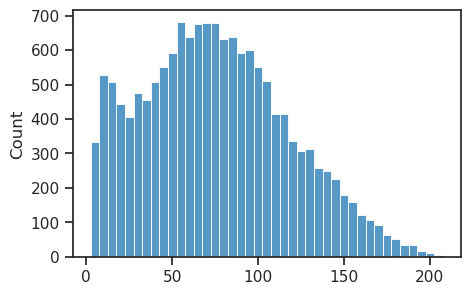

In [8]:
num_bins = 42
bin_edges = (5, 210)
bins = np.linspace(*bin_edges, num_bins)
bins -= 2.5

sns.histplot(deg.ravel(), bins=bins);

#### Binary

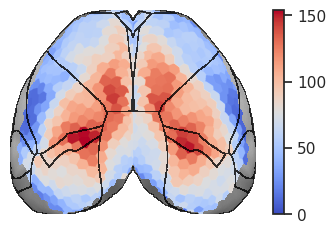

In [9]:
_ = bs.show(
    data=bn.nanmean(deg, 0),
    figsize=(4, 2.5),
    vmin=0,
    vmax=None,
    add_disjoint=False,
    contour_cmap='Greys_r',
    cmap='coolwarm',
    cbar=True,
)

#### Weighted

In [10]:
a = bn.nanmean(adjacencies, 0)
a.shape

(540, 540)

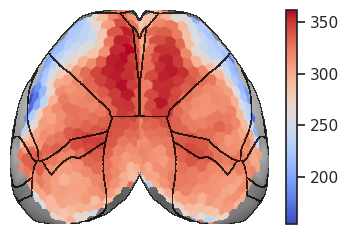

In [11]:
_ = bs.show(
    data=np.nansum(a, 0),
    figsize=(4, 2.5),
    vmin=None,
    vmax=None,
    add_disjoint=False,
    contour_cmap='Greys_r',
    cmap='coolwarm',
    cbar=True,
)

## KMeans

In [12]:
a = bn.nanmean(adjacencies, 0)
a[np.isnan(a)] = 0
a.shape

(540, 540)

In [13]:
num_clusters = range(2, 9)
partition = np_nans((len(num_clusters), len(a)))
for i, k in enumerate(num_clusters):
    centroids, km = fit_kmeans(a, k, 'euclidean')
    partition[i] = km.predict(a) + 1

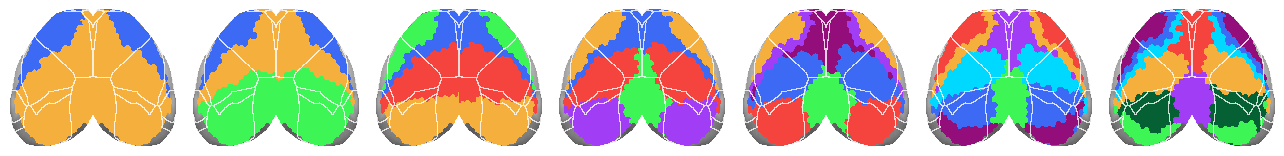

In [14]:
_ = bs.show(
    partition,
    vmin=1,
    vmax=k,
    interp='none',
    figsize=(13, 5),
    cmap=get_cluster_cmap(range(k)),
)

## Region-wise connectivity

In [15]:
x = bn.nanmean(a_bin, 0)
x.shape

(540, 540)

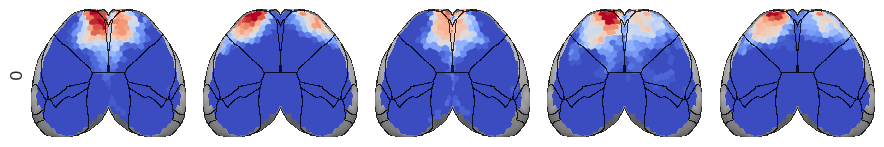

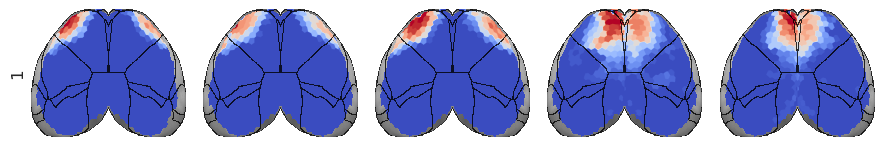

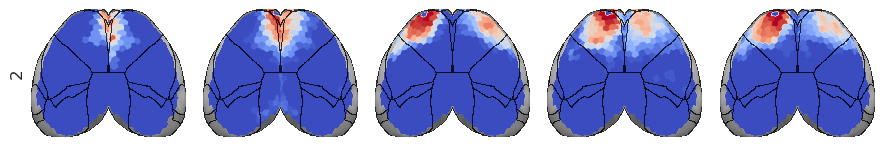

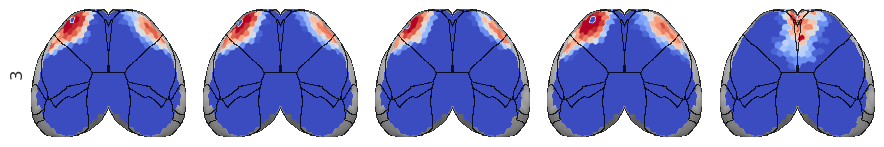

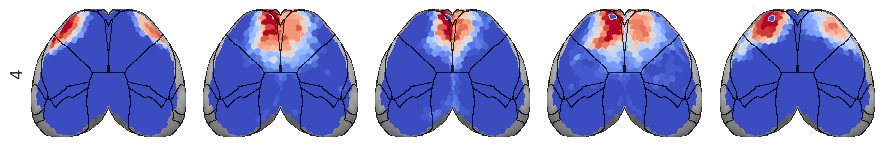

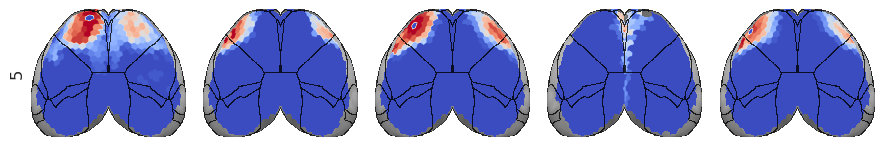

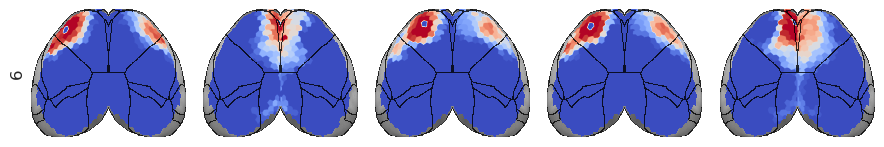

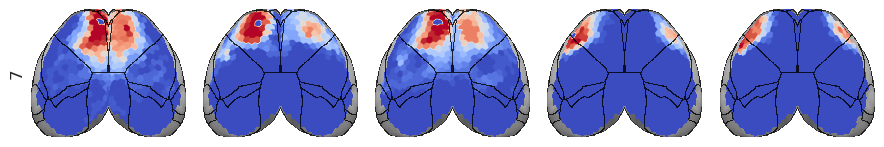

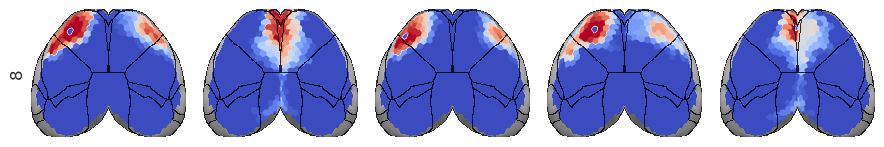

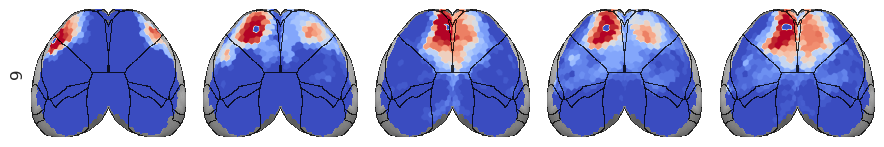

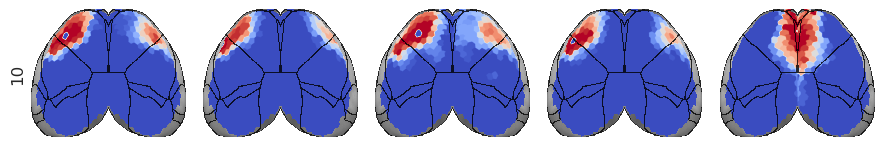

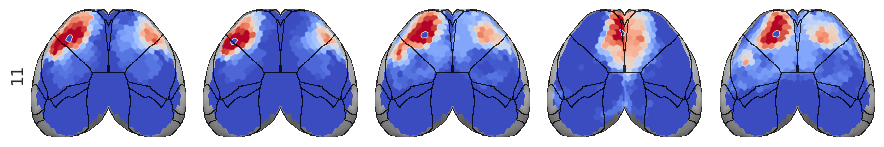

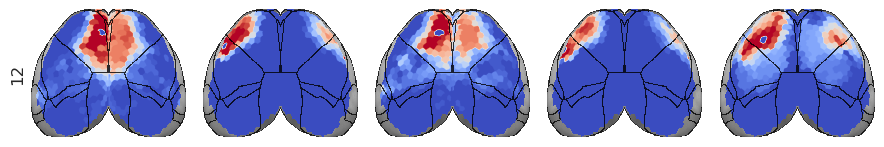

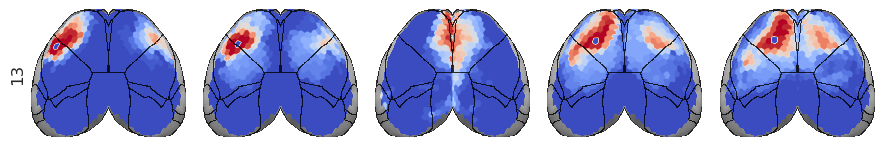

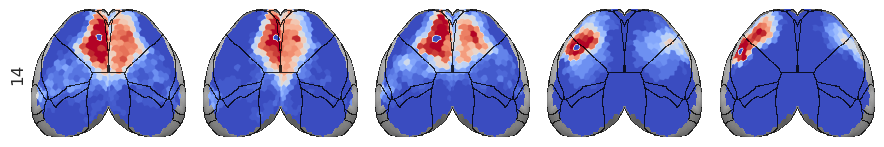

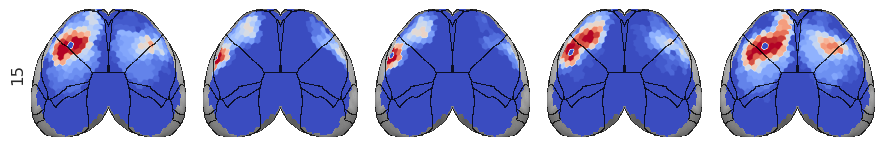

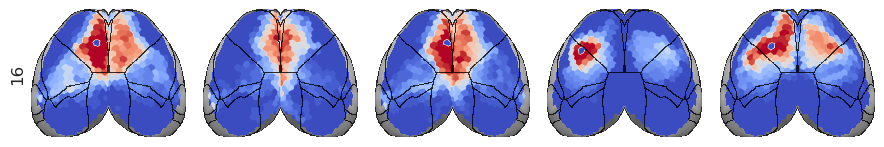

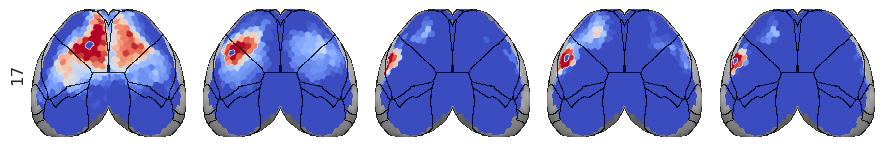

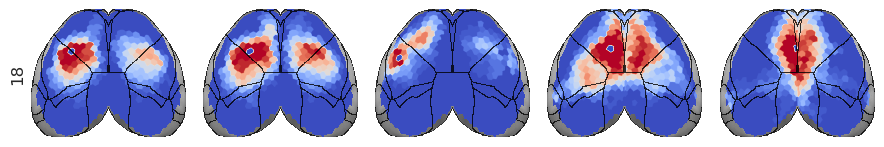

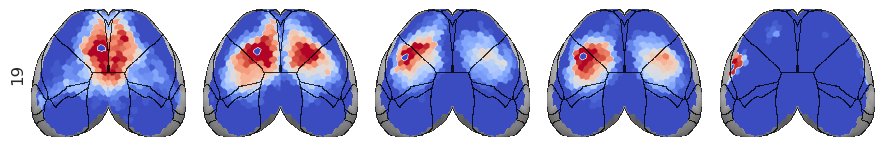

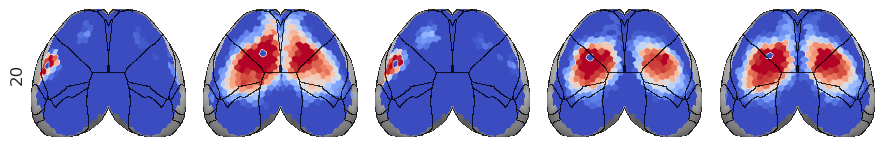

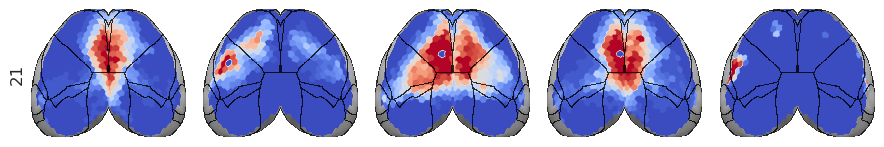

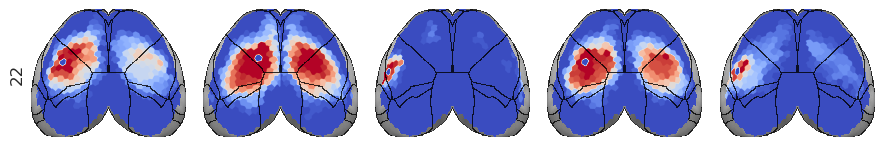

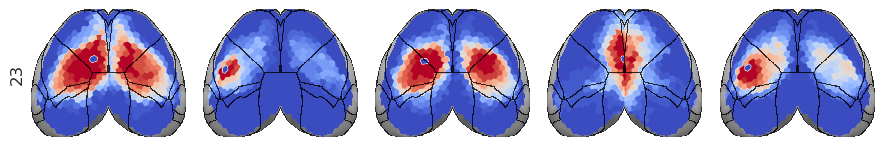

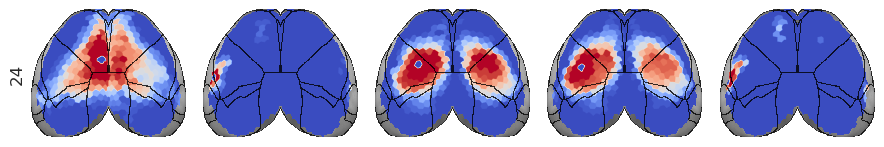

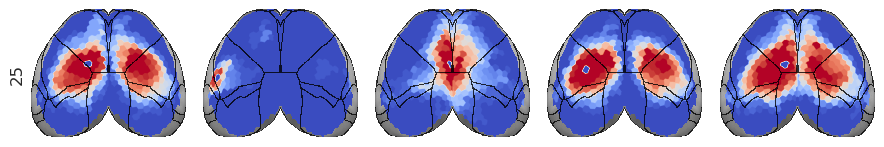

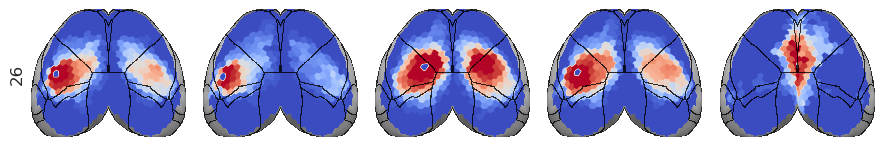

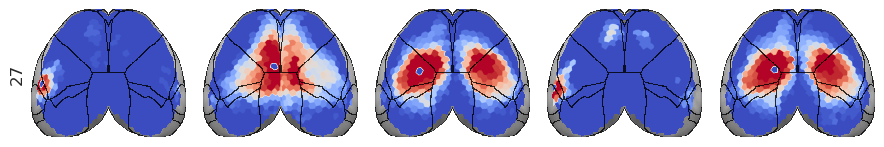

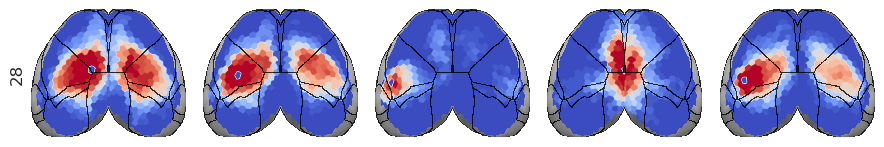

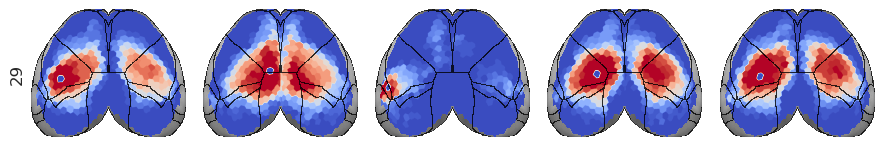

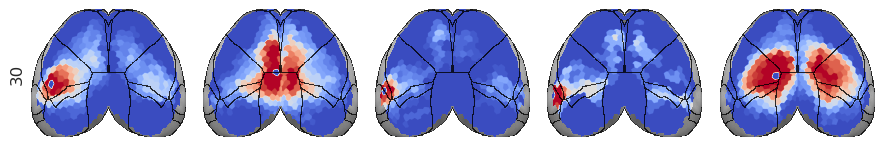

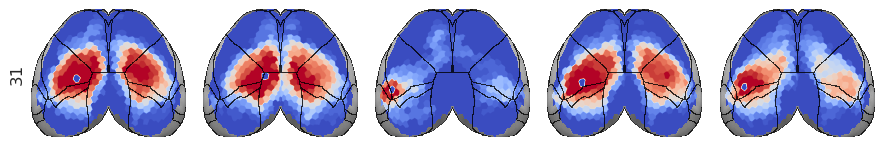

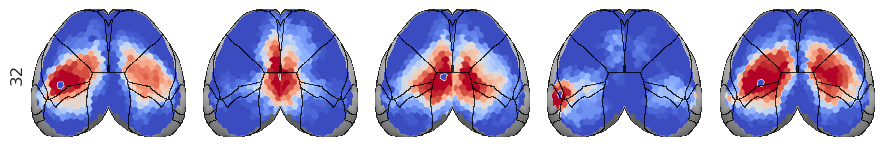

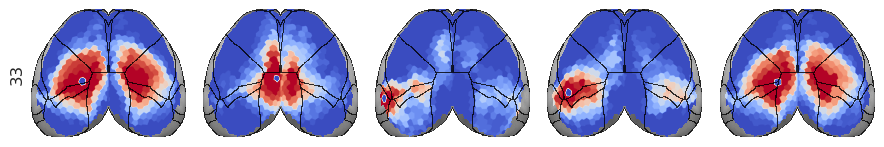

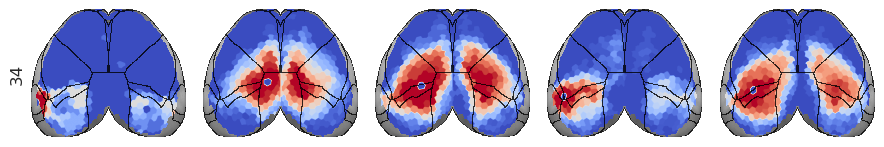

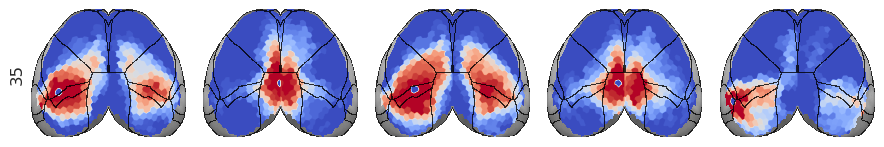

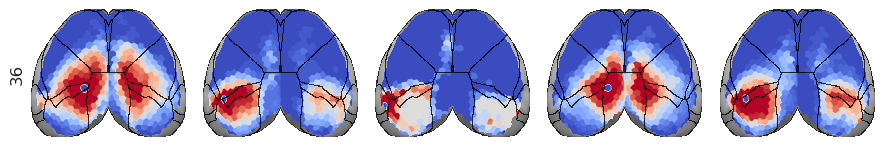

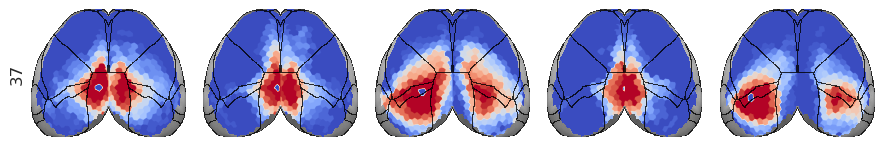

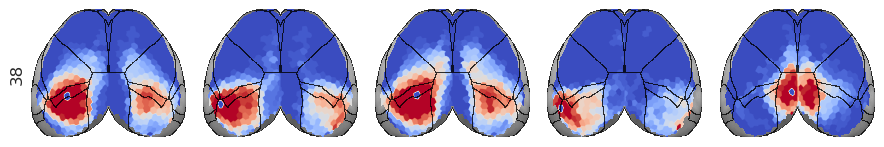

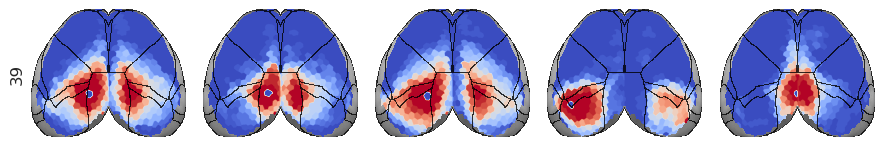

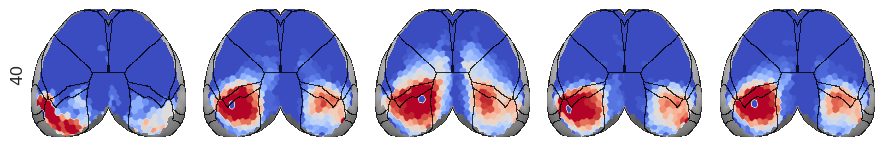

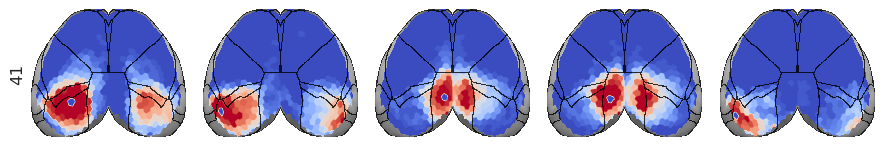

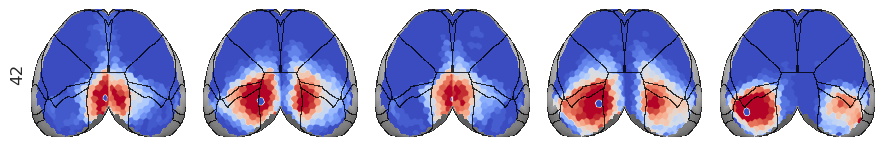

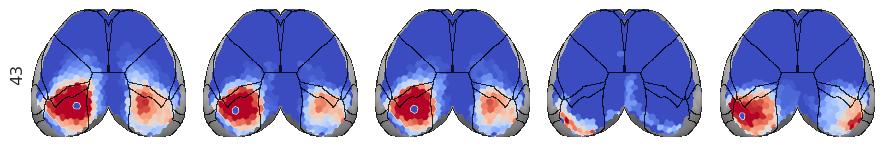

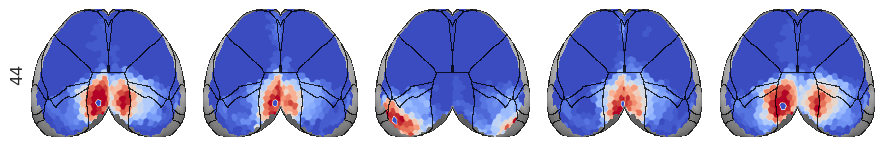

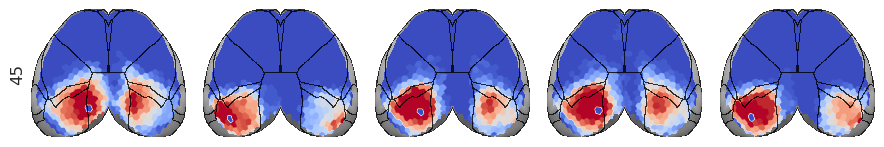

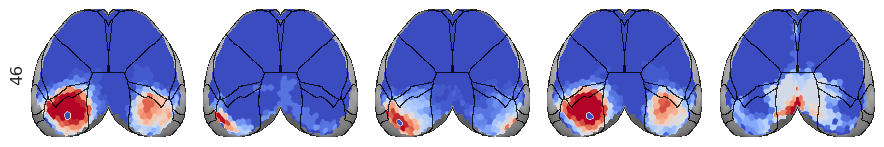

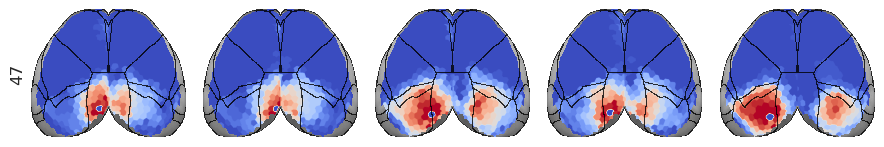

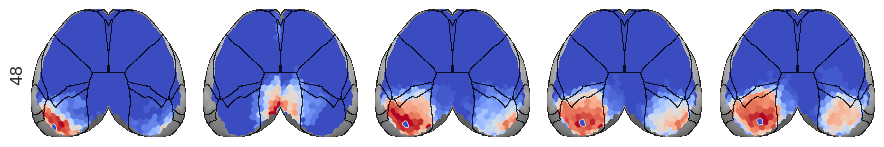

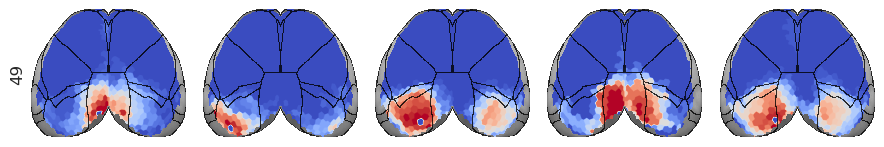

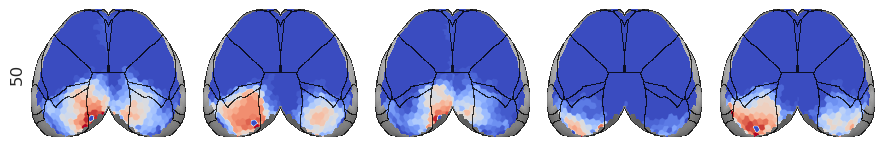

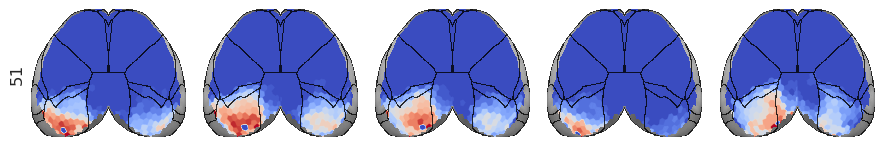

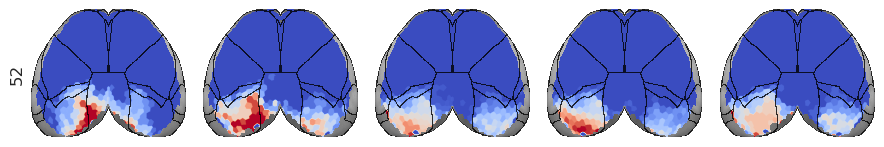

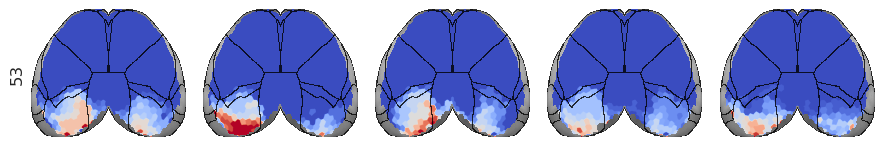

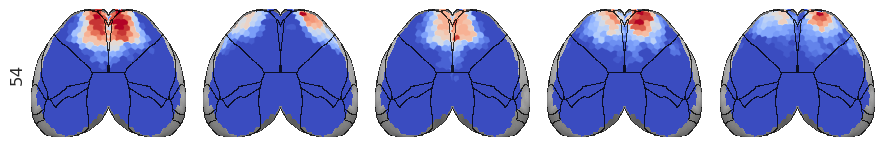

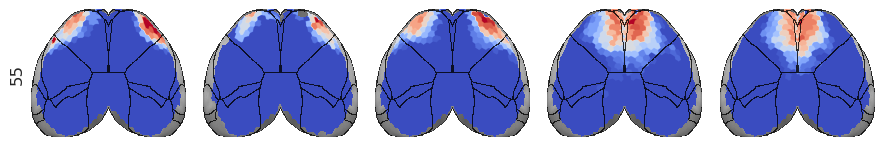

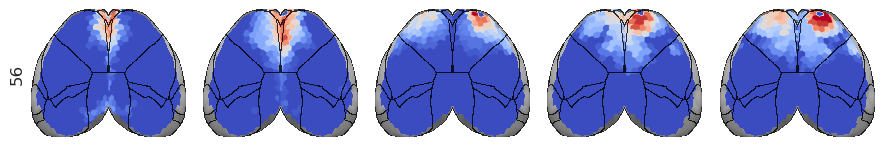

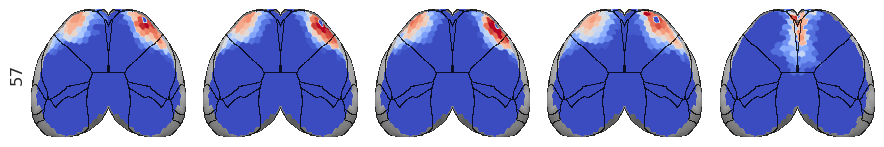

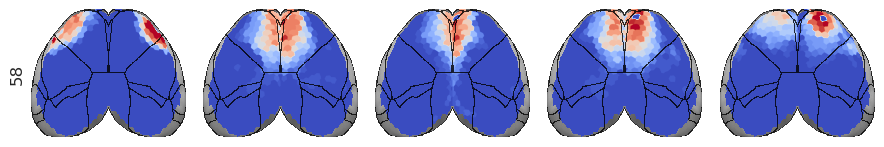

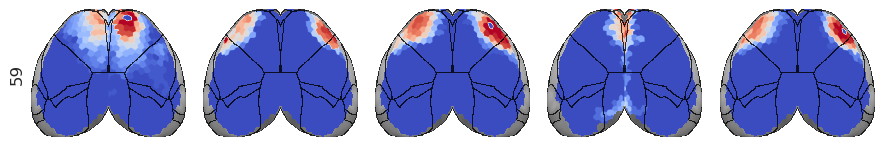

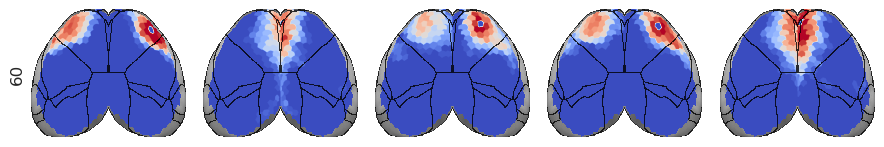

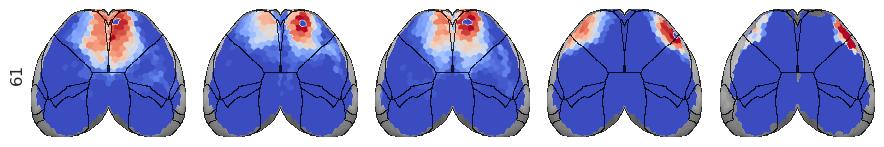

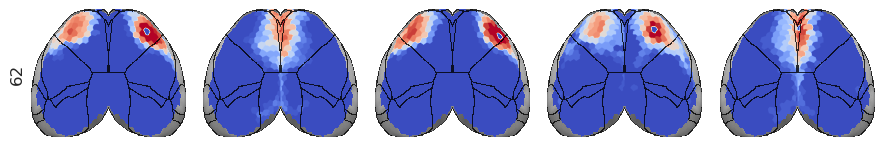

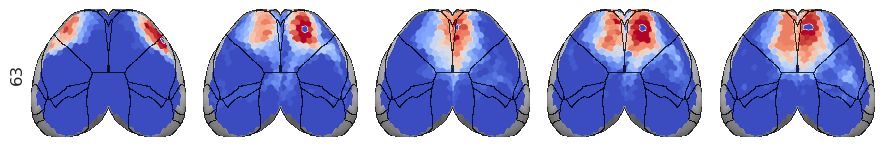

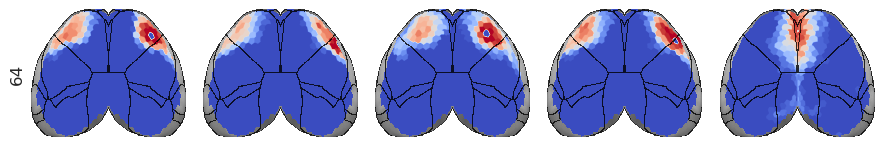

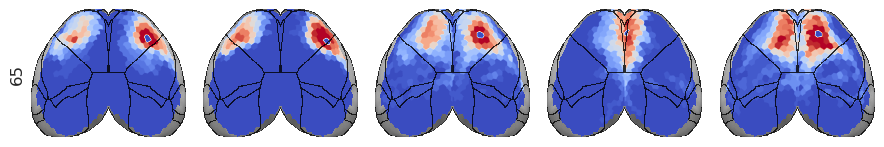

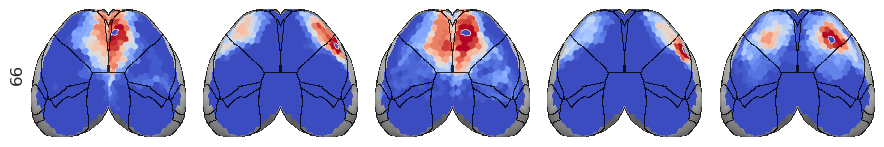

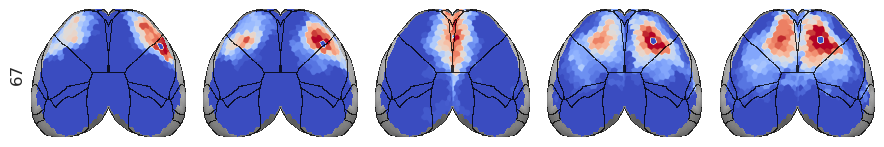

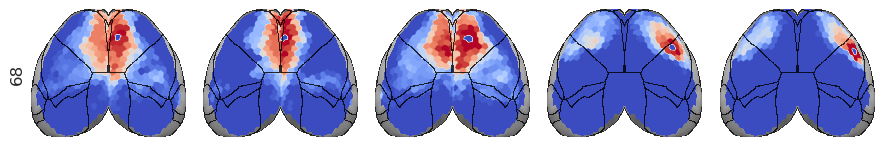

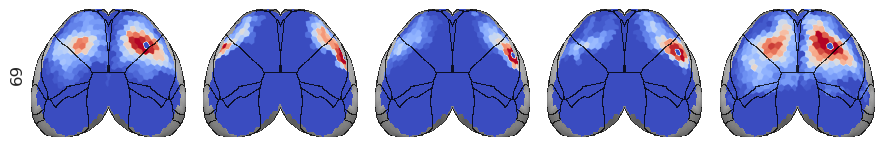

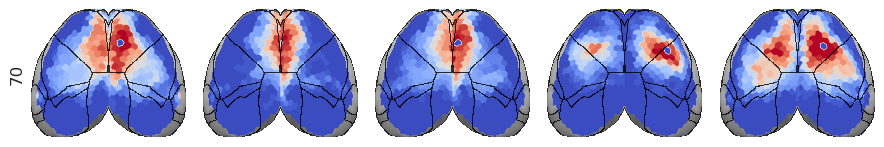

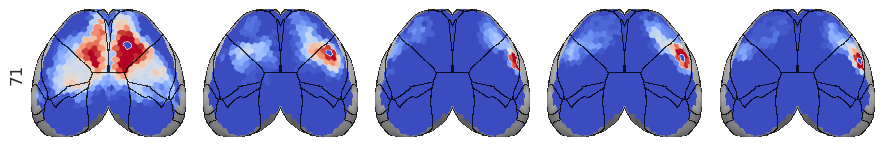

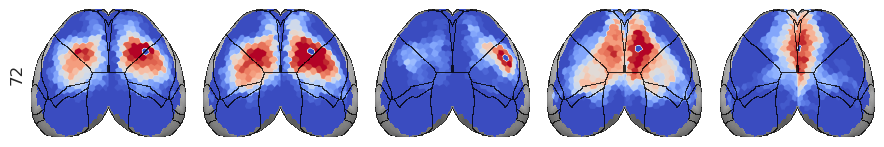

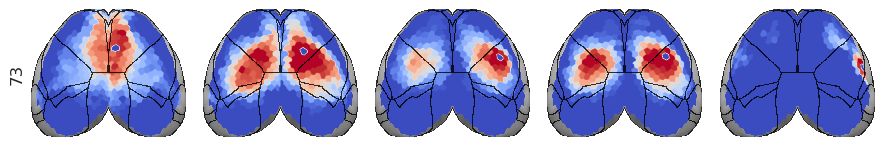

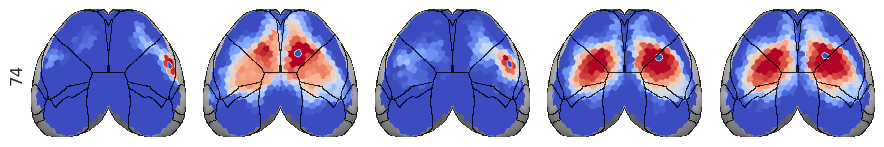

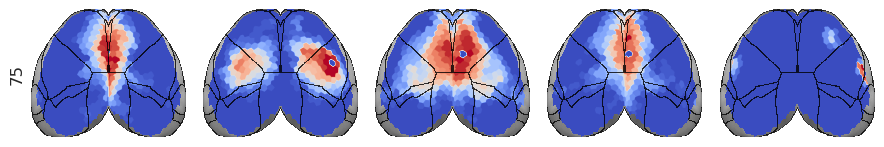

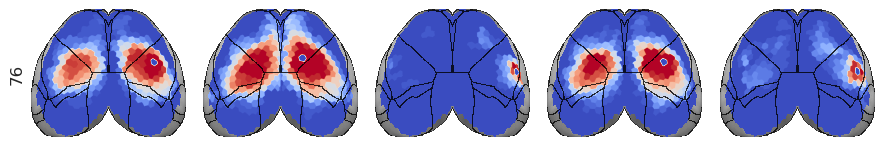

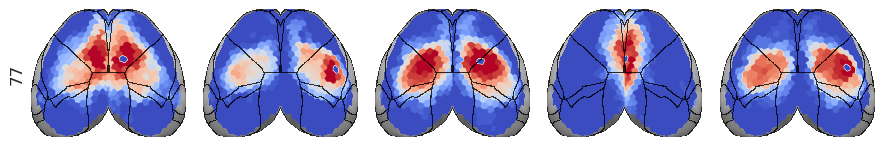

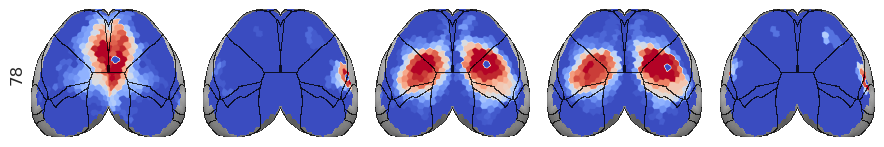

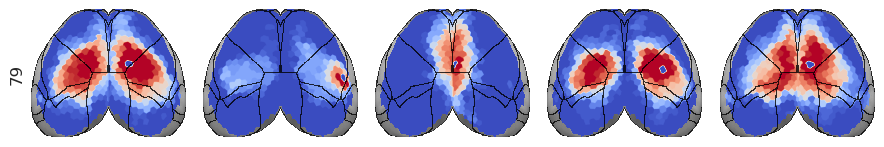

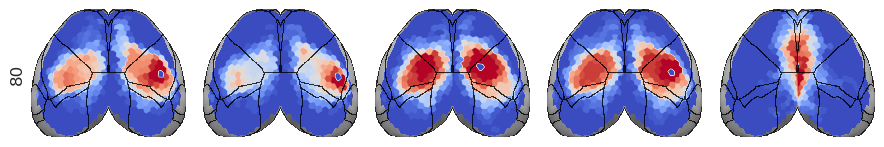

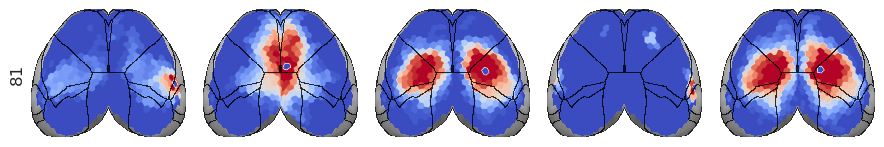

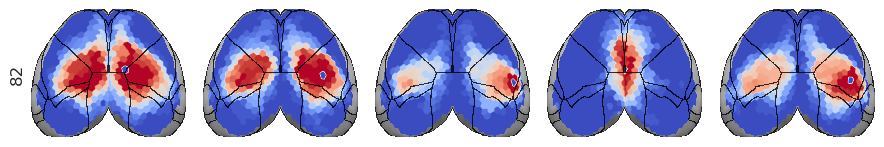

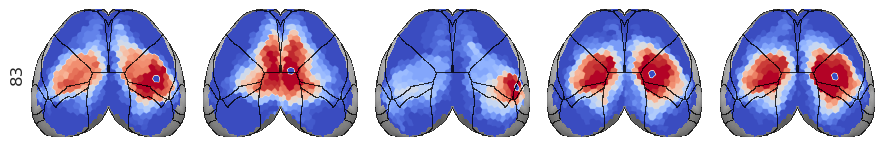

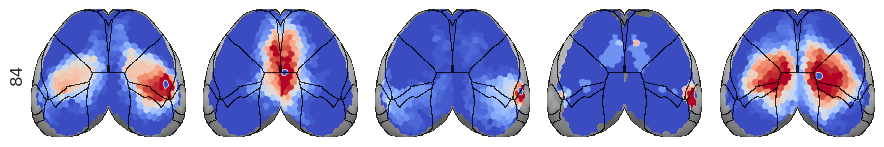

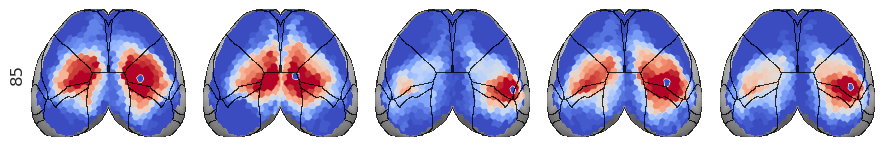

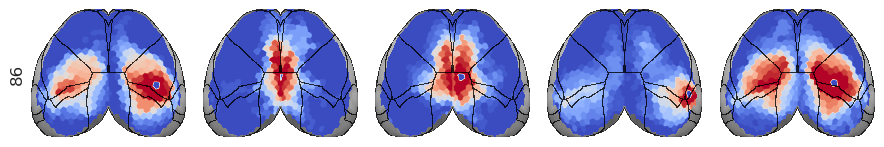

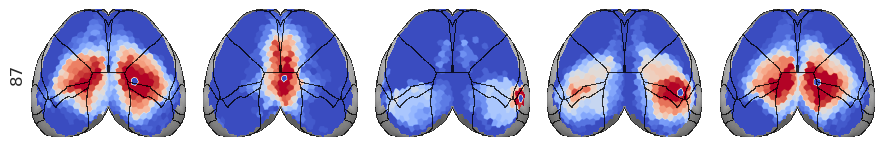

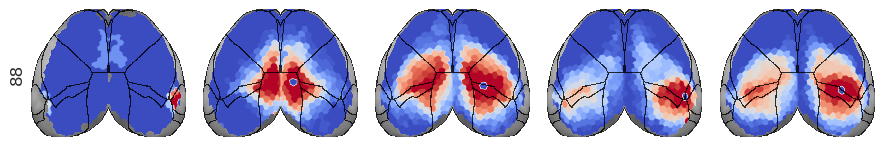

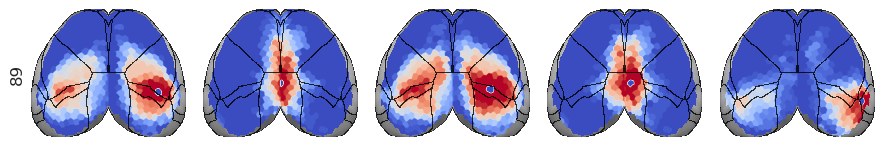

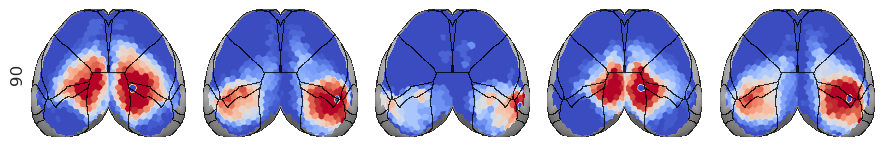

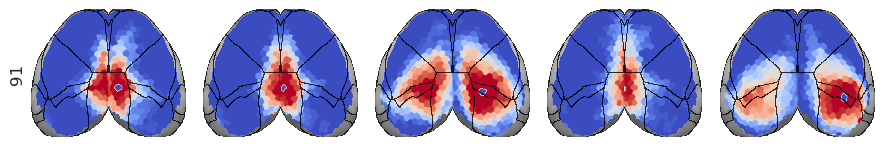

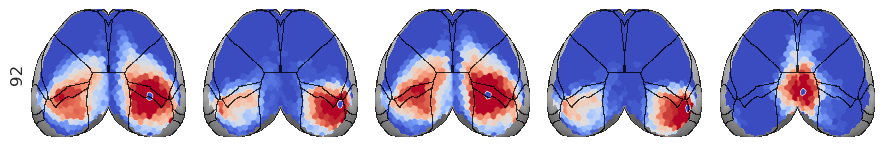

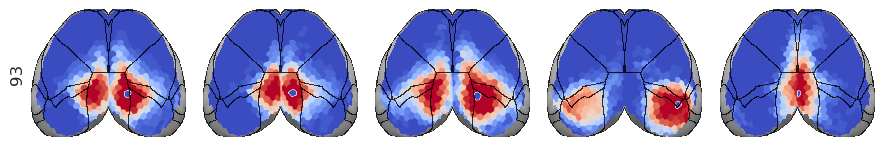

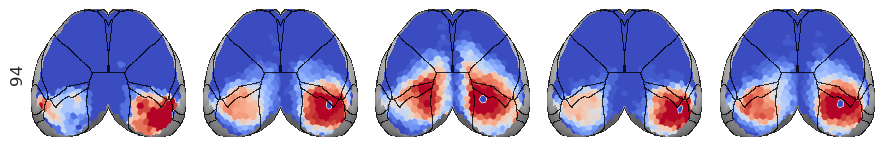

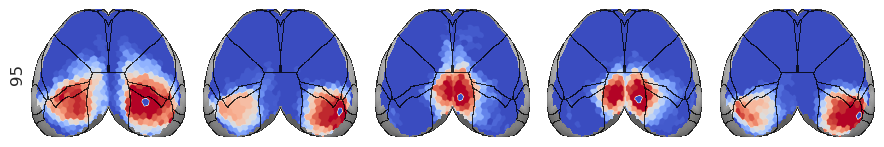

In [16]:
for i in range(int(np.ceil(480 / 5))):
    _ = bs.show(
        data={i: x[i*5:(i+1)*5]},
        figsize=(9, 1.8),
        vmin=0,
        vmax=None,
        add_disjoint=False,
        contour_cmap='Greys_r',
        cmap='coolwarm',
        cbar=False,
    )